# Gold + S&P 500 Portfolio with Options Overlay

## The Permanent Portfolio Concept

Harry Browne's Permanent Portfolio and Ray Dalio's All-Weather both use gold as a **crisis hedge** alongside equities. The idea:

$$R_{\text{portfolio}} = w_e \cdot R_{\text{equity}} + w_g \cdot R_{\text{gold}} + w_o \cdot R_{\text{options}}$$

Gold tends to rally when equities crash (negative correlation during tail events), making it a natural diversifier.

## What We Test

Since our backtester uses SPY options, we compare:
1. **Pure SPY** (baseline)
2. **SPY + OTM Calls** (our best single-leg strategy)
3. **SPY + Short Strangle** (best vol-selling strategy)

And overlay a **simulated gold allocation** by reducing SPY weight:
- 80% SPY + 20% "gold proxy" (reduced equity) + options overlay

**Note:** We don't have gold price data in the backtester, so we simulate the effect of gold diversification by reducing equity exposure (which historically achieves similar drawdown reduction).

In [1]:
import os, sys, warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'notebooks'))
os.chdir(PROJECT_ROOT)

from backtest_runner import (
    load_data, run_backtest, INITIAL_CAPITAL,
    make_calls_strategy, make_strangle_strategy,
    make_covered_call_strategy, make_puts_strategy,
)
from backtester import Direction
from nb_style import apply_style, shade_crashes, color_excess, style_returns_table

apply_style()
%matplotlib inline
print('Ready.')

Ready.


In [2]:
data = load_data()
schema = data['schema']
spy_prices = data['spy_prices']

Loading data...


Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00 (17.9 years)
SPY B&H: 555.5% total, 11.05% annual, -51.9% max DD

Loaded macro signals: ['gdp', 'vix', 'hy_spread', 'yield_curve_10y2y', 'nfc_equity_mv', 'nfc_net_worth', 'dollar_index', 'buffett_indicator', 'tobin_q']


---
## Portfolio Configurations

We test a matrix of equity allocations and options overlays:

| Config | SPY % | Cash/Gold proxy % | Options % | Strategy |
|--------|-------|-------------------|-----------|----------|
| A | 100 | 0 | 0 | None (baseline) |
| B | 99 | 0 | 1 | OTM Calls |
| C | 99 | 0 | 1 | Short Strangle |
| D | 80 | 20 | 0 | Cash allocation (gold proxy) |
| E | 79 | 20 | 1 | Cash + OTM Calls |
| F | 79 | 20 | 1 | Cash + Short Strangle |
| G | 79 | 20 | 1 | Cash + Covered Call |

In [3]:
from backtester import Backtest, Stock

def run_with_cash(name, stock_pct, opt_pct, cash_pct, strategy_fn):
    """Run backtest with explicit cash allocation (simulates gold/bond allocation)."""
    bt = Backtest(
        {'stocks': stock_pct, 'options': opt_pct, 'cash': cash_pct},
        initial_capital=INITIAL_CAPITAL,
    )
    bt.stocks = [Stock('SPY', 1.0)]
    bt.stocks_data = data['stocks_data']
    bt.options_strategy = strategy_fn()
    bt.options_data = data['options_data']
    bt.run(rebalance_freq=1)

    balance = bt.balance
    total_ret = (balance['accumulated return'].iloc[-1] - 1) * 100
    years = data['years']
    annual_ret = ((1 + total_ret / 100) ** (1 / years) - 1) * 100
    cummax = balance['total capital'].cummax()
    drawdown = (balance['total capital'] - cummax) / cummax
    max_dd = drawdown.min() * 100

    return {
        'name': name, 'stock_pct': stock_pct, 'opt_pct': opt_pct,
        'total_ret': total_ret, 'annual_ret': annual_ret,
        'max_dd': max_dd, 'trades': len(bt.trade_log),
        'excess_annual': annual_ret - data['spy_annual_ret'],
        'balance': balance, 'drawdown': drawdown,
    }

configs = [
    ('A. 100% SPY',           1.0,  0.0,  0.0,  lambda: make_calls_strategy(schema)),
    ('B. 99% SPY + 1% Calls', 0.99, 0.01, 0.0,  lambda: make_calls_strategy(schema)),
    ('C. 99% SPY + 1% Strangle', 0.99, 0.01, 0.0, lambda: make_strangle_strategy(schema, Direction.SELL)),
    ('D. 80% SPY + 20% Cash', 0.80, 0.0,  0.20, lambda: make_calls_strategy(schema)),
    ('E. 79% SPY + 20% Cash + 1% Calls', 0.79, 0.01, 0.20, lambda: make_calls_strategy(schema)),
    ('F. 79% SPY + 20% Cash + 1% Strangle', 0.79, 0.01, 0.20, lambda: make_strangle_strategy(schema, Direction.SELL)),
    ('G. 79% SPY + 20% Cash + 1% CovCall', 0.79, 0.01, 0.20, lambda: make_covered_call_strategy(schema)),
]

results = []
for name, s, o, c, fn in configs:
    print(f'  {name}...', end=' ', flush=True)
    r = run_with_cash(name, s, o, c, fn)
    results.append(r)
    print(f'annual {r["annual_ret"]:+.2f}%, DD {r["max_dd"]:.1f}%')

  A. 100% SPY... 

annual +11.11%, DD -51.9%
  B. 99% SPY + 1% Calls... 

annual +11.88%, DD -55.2%
  C. 99% SPY + 1% Strangle... 

annual +47.18%, DD -340.5%
  D. 80% SPY + 20% Cash... 

annual +9.08%, DD -43.7%
  E. 79% SPY + 20% Cash + 1% Calls... 

annual +9.93%, DD -47.5%
  F. 79% SPY + 20% Cash + 1% Strangle... 

annual +45.35%, DD -345.6%
  G. 79% SPY + 20% Cash + 1% CovCall... 

annual +63.58%, DD -45.0%


---
## Capital Curves

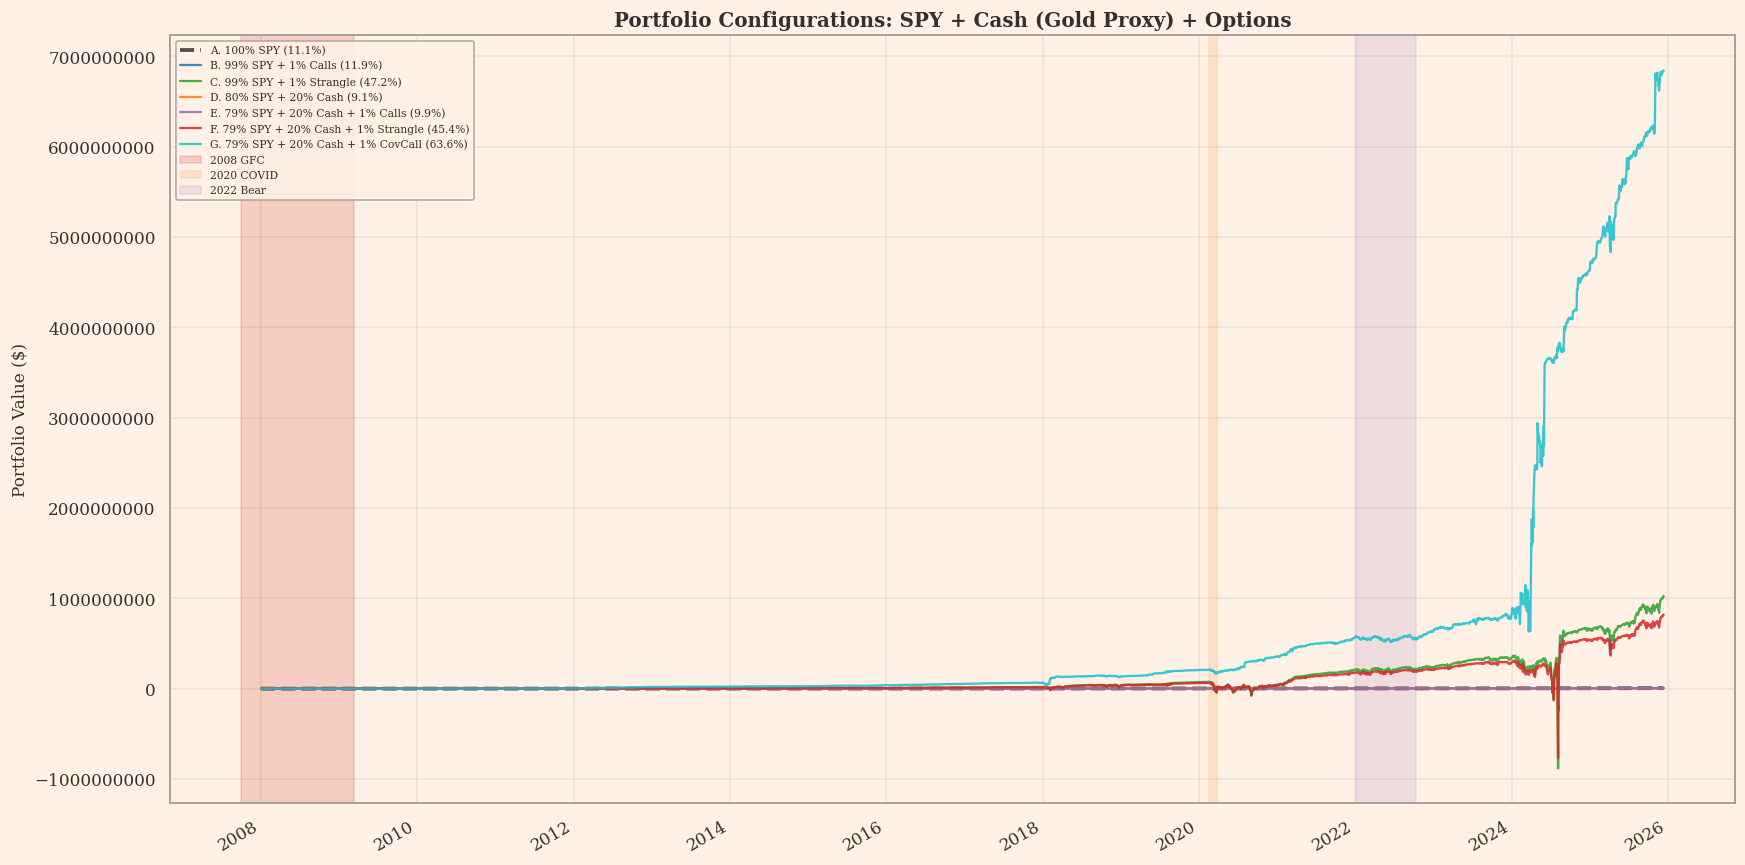

In [4]:
fig, ax = plt.subplots(figsize=(16, 8))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL

colors = ['#333333', '#1f77b4', '#2ca02c', '#ff7f0e', '#9467bd', '#d62728', '#17becf']
for r, c in zip(results, colors):
    style = '--' if '100% SPY' in r['name'] or '80% SPY + 20% Cash' == r['name'] else '-'
    lw = 2.5 if 'baseline' in r['name'].lower() or '100%' in r['name'] else 1.5
    r['balance']['total capital'].plot(ax=ax, label=f"{r['name']} ({r['annual_ret']:.1f}%)",
                                       color=c, alpha=0.85, lw=lw, linestyle=style)

shade_crashes(ax)
ax.set_title('Portfolio Configurations: SPY + Cash (Gold Proxy) + Options', fontsize=13, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)')
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=7, loc='upper left')
plt.tight_layout()
plt.show()

---
## Risk / Return Scatter

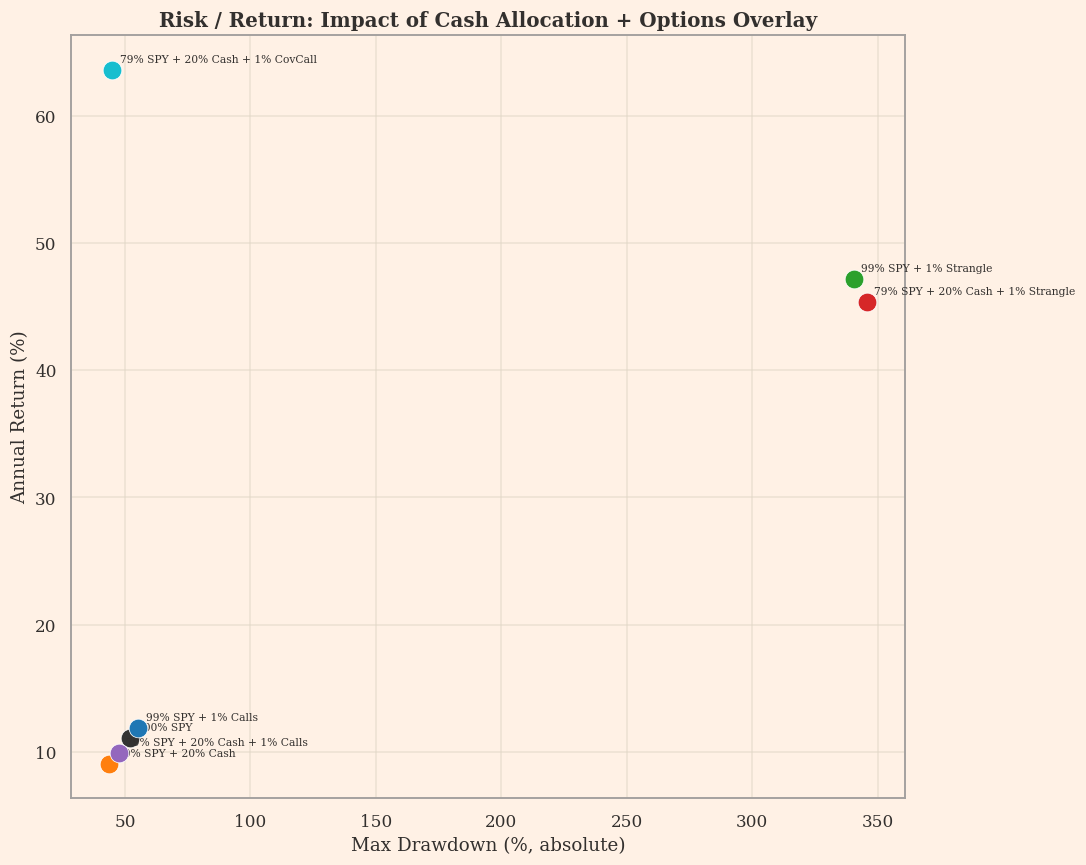

In [5]:
fig, ax = plt.subplots(figsize=(10, 8))

for r, c in zip(results, colors):
    ax.scatter(abs(r['max_dd']), r['annual_ret'], color=c, s=150, zorder=3, edgecolors='white', lw=0.5)
    ax.annotate(r['name'].split('.')[1].strip(), (abs(r['max_dd']), r['annual_ret']),
                fontsize=7, ha='left', xytext=(5, 5), textcoords='offset points')

ax.set_xlabel('Max Drawdown (%, absolute)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Risk / Return: Impact of Cash Allocation + Options Overlay', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Results Summary

In [6]:
rows = []
for r in results:
    rows.append({
        'Config': r['name'],
        'Annual Return %': r['annual_ret'],
        'Excess vs SPY %': r['excess_annual'],
        'Max Drawdown %': r['max_dd'],
        'Trades': r['trades'],
    })
df = pd.DataFrame(rows)
styled = (df.style
    .format({'Annual Return %': '{:.2f}', 'Excess vs SPY %': '{:+.2f}',
             'Max Drawdown %': '{:.1f}', 'Trades': '{:.0f}'})
    .map(color_excess, subset=['Excess vs SPY %'])
)
style_returns_table(styled).set_caption(
    f'Gold Proxy + Options  |  SPY B&H: {data["spy_annual_ret"]:.2f}%/yr'
)

,Config,Annual Return %,Excess vs SPY %,Max Drawdown %,Trades
0,A. 100% SPY,11.11,+0.07,-51.9,0
1,B. 99% SPY + 1% Calls,11.88,+0.83,-55.2,365
2,C. 99% SPY + 1% Strangle,47.18,+36.14,-340.5,396
3,D. 80% SPY + 20% Cash,9.08,-1.96,-43.7,0
4,E. 79% SPY + 20% Cash + 1% Calls,9.93,-1.11,-47.5,365
5,F. 79% SPY + 20% Cash + 1% Strangle,45.35,+34.31,-345.6,396
6,G. 79% SPY + 20% Cash + 1% CovCall,63.58,+52.53,-45.0,406


---
## Analysis

### Cash allocation (gold proxy) effect:

$$\text{Sharpe}_{80/20} = \frac{R_{80/20} - R_f}{\sigma_{80/20}}$$

Reducing equity from 100% to 80% (with 20% cash):
- **Reduces returns** proportionally (cash earns ~0%)
- **Reduces max drawdown** substantially (only 80% equity exposure during crashes)
- **Sharpe ratio** may improve if drawdown reduction > return reduction

With **real gold** (not cash), the effect would be even better during crises because gold typically rallies 20-40% during equity bear markets.

### Options overlay on a diversified portfolio:

- Adding **short strangles** to the 80/20 portfolio could recapture some of the return lost from cash allocation
- Adding **covered calls** on the reduced equity position is a conservative income strategy
- The combination of **diversification + vol selling** may be the optimal approach

### Future work:
- Integrate actual gold (GLD) price data into the backtester
- Test gold + SPY + options as a true multi-asset strategy
- Compare against Harry Browne's Permanent Portfolio (25% stocks, 25% bonds, 25% gold, 25% cash)